In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from neuralnet import NeuralNetMLP
import seaborn as sns

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
X = X.values
y = y.astype(int).values

In [4]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
# Normalize X pixel values to between -1 and 1.
X = ((X/ 255.)) - .5 * 2

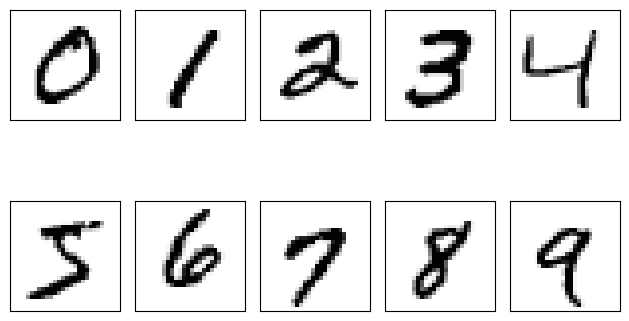

In [7]:
# Plot images
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28,28) # get first example of each digit and reshape
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
    

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp
)

In [14]:
def int_to_onehot(y, num_labels):
    # Converts vector y with n_labels into matrix of shape (len(y), num_labels)
    arr = np.zeros((y.shape[0], num_labels))
    for idx, val in enumerate(y):
        arr[idx, val] = 1
    return arr

## Neural network training loop

In [10]:
n_epochs = 50
minibatch_size = 100

In [13]:
model = NeuralNetMLP(n_features=28*28,
                     n_hidden=50,
                     n_classes=10)

In [11]:
def minibatch_generator(X, y, minibatch_size):
    '''
    Generate a batch of size 'minibatch_size' from X and y.
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1,
                           minibatch_size):
        batch_idxs = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idxs], y[batch_idxs]

In [12]:
# Iterate over training epochs
for i in range(n_epochs):
    # Iterate over minibatches.
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break # Breaks just to test that minibatches are being created in the correct size.
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [15]:
# Define functions for the loss and accuracy.
def mse_loss(targets, probas, n_labels=10):
    onehot_targets = int_to_onehot(
        targets, n_labels
    )
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, preds):
    return np.mean(preds == targets)

In [17]:
# Test functions with an initial forward pass.
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc*100: .1f}%')

Initial validation MSE: 0.3
Initial validation accuracy:  9.9%


In [18]:
def compute_mse_and_acc(nnet, X, y, n_labels=10, minibatch_size=100):
    '''
    Computes MSE and accuracy on minibatches of samples, X. Return the totals across minimbatches.
    '''
    mse, correct_preds, n_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, n_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_preds += (predicted_labels == targets).sum()
        n_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_preds/ n_examples
    return mse, acc

In [19]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100: .1f}%')

Initial validation MSE: 0.3
Initial validation accuracy:  9.9%


In [20]:
range?

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     

In [23]:
def train(model, X_train, y_train, X_valid, y_valid, n_epochs, lr=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(n_epochs):
        # Iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:

            ### Compute Outputs ###
            a_h, a_out = model.forward(X_train_mini)

            ### Compute Gradients ###
            dLoss_dw_out, dLoss_db_out, dLoss_dw_h, dLoss_db_h = \
            model.backward(X_train_mini, a_h, a_out, y_train_mini)

            ### Update Gradients ###
            model.w_h -= lr * dLoss_dw_h
            model.b_h -= lr * dLoss_db_h
            model.w_out -= lr * dLoss_dw_out
            model.b_out -= lr * dLoss_db_out
    
        ### Epoch Logging ###
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:}/{n_epochs} '
              f'| Train MSE: {train_mse:.2f}'
              f'| Train Acc: {train_acc:.2f}'
              f'| Valid Acc: {valid_acc:.2f}')
    
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [24]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = \
train(model, X_train, y_train, X_valid, y_valid, n_epochs=50, lr=0.1)

Epoch: 1/50 | Train MSE: 0.08| Train Acc: 41.64| Valid Acc: 41.48
Epoch: 2/50 | Train MSE: 0.05| Train Acc: 71.31| Valid Acc: 71.00
Epoch: 3/50 | Train MSE: 0.04| Train Acc: 82.20| Valid Acc: 82.24
Epoch: 4/50 | Train MSE: 0.03| Train Acc: 85.78| Valid Acc: 85.88
Epoch: 5/50 | Train MSE: 0.03| Train Acc: 87.39| Valid Acc: 87.52
Epoch: 6/50 | Train MSE: 0.02| Train Acc: 88.29| Valid Acc: 88.62
Epoch: 7/50 | Train MSE: 0.02| Train Acc: 88.83| Valid Acc: 89.06
Epoch: 8/50 | Train MSE: 0.02| Train Acc: 89.20| Valid Acc: 89.34
Epoch: 9/50 | Train MSE: 0.02| Train Acc: 89.82| Valid Acc: 89.90
Epoch: 10/50 | Train MSE: 0.02| Train Acc: 90.15| Valid Acc: 90.18
Epoch: 11/50 | Train MSE: 0.02| Train Acc: 90.49| Valid Acc: 90.88
Epoch: 12/50 | Train MSE: 0.02| Train Acc: 90.74| Valid Acc: 90.96
Epoch: 13/50 | Train MSE: 0.02| Train Acc: 90.76| Valid Acc: 90.88
Epoch: 14/50 | Train MSE: 0.02| Train Acc: 91.10| Valid Acc: 91.24
Epoch: 15/50 | Train MSE: 0.02| Train Acc: 91.16| Valid Acc: 91.32
Epoc

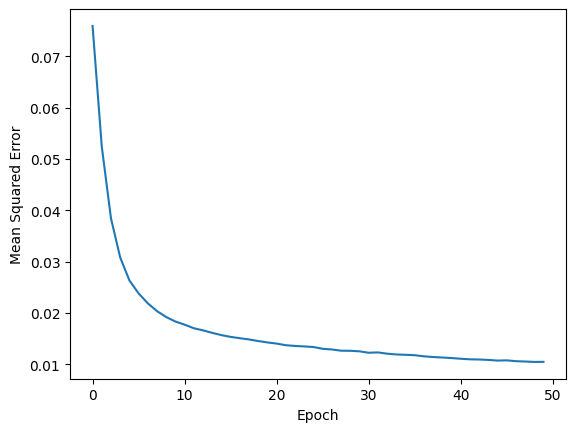

In [26]:
# Plot training loss
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

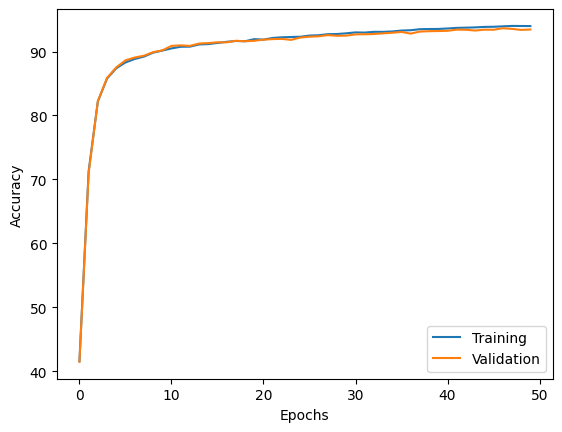

In [28]:
# Plot training and validation accuracy
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Evaluation generalization performance on the test set.
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 93.42%
